In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [94]:
# Reading Customer Data
customer_data = pd.read_csv('QVI_purchase_behaviour.csv')

In [95]:
# Reading Transactional Data
transaction_data = pd.read_excel('QVI_transaction_data.xlsx')

In [96]:
transaction_data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [97]:
customer_data.head(5)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


### Exploratory Data Analysis

#### Transaction Data

In [98]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [99]:
# Changing Data Column into date format
transaction_data['DATE'] = transaction_data['DATE'].apply(lambda x: dt.datetime(1899, 12, 30) + dt.timedelta(days=x))

In [100]:
# Finding all words in PROD_NAME and deleting all rows not having chips

l = list(transaction_data['PROD_NAME'].unique())

# Removing any special letters/symbols from product names and listing out all the words
word_list = []
for wordstr in l:
    words = re.sub(r'[^A-Za-z\s]','',wordstr).split()
    word_list.extend(words)


# Counting frequency of words
word_count = Counter(word_list)

In [101]:
# Creating frequency Data Frame of words in decreasing order
freq_df = pd.DataFrame(word_count.items(), columns = ['Word', 'Frequency'])
freq_df = freq_df.sort_values(by= 'Frequency', ascending = False).reset_index(drop = True)

In [102]:
freq_df.head(10)

,Word,Frequency
0,g,105
1,Chips,21
2,Smiths,16
3,Cut,14
4,Crinkle,14
5,Kettle,13
6,Salt,12
7,Cheese,12
8,Original,10
9,Salsa,9


Since, there are Salsa products in some rows, we will remove those from the dataset.

In [103]:
# Removing rows having Salsa products
transaction_data = transaction_data[-transaction_data['PROD_NAME'].str.contains('Salsa', case = False, na = False)]

In [104]:
# Checking for any null values in transaction dataset
transaction_data.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

In [105]:
# Let's check summary statistics to see any discrepancy
transaction_data.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [106]:
#Let's define a range to check for outliers. Any transaction outside the range is outlier.

# Checking for PROD_QTY
# Min_Max Range  = Q1 - 1.5*(IQR), Q3 + 1.5*(IQR)
q1 = transaction_data['PROD_QTY'].quantile(0.25)
q3 = transaction_data['PROD_QTY'].quantile(0.75)
lower = q1 - 1.5*(q3-q1)
upper = q3 + 1.5*(q3-q1)
print(f'Min_Max_Range: ({lower},{upper})')

Min_Max_Range: (2.0,2.0)


In [107]:
# Looks like there are some outlier transactions in the data.
transaction_data['PROD_QTY'].unique()

array([  2,   3,   5,   1,   4, 200], dtype=int64)

In [108]:
# Finding outlier transactions
transaction_data[transaction_data['PROD_QTY'] > 5]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [109]:
# Checking if the customer has any other odd transactions
indx = transaction_data[transaction_data['LYLTY_CARD_NBR'] == 226000].index
indx

Int64Index([69762, 69763], dtype='int64')

In [110]:
# Dropping customer loyalty card number from the data
transaction_data.drop(indx, inplace = True)

In [111]:
# Let's check summary statistics again
transaction_data.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
std,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000


In [112]:
# Checking count of transactions by date

transactions_by_date = transaction_data.groupby('DATE')['LYLTY_CARD_NBR'].count()
trans_df = pd.DataFrame(transactions_by_date).reset_index().rename(columns = {'DATE':'Date','LYLTY_CARD_NBR':'Count'})

#### There are 364 dates in the above table. This means, we are missing one date. Let's try to find it out.

In [113]:
# Creating a series of dates from 2018-07-01 to 2019-06-30

import datetime

start_date = datetime.date(2018,7,1)
k = 365 # number of dates required after start date

date_list = []
for day in range(k):
    date = (start_date + datetime.timedelta(days = day)).isoformat()
    date_list.append(date)
    
date_list_df = pd.DataFrame(date_list, columns = ['Date'])
date_list_df['Date'] = date_list_df['Date'].astype('datetime64')

In [114]:
# Merging count column from transactions DataFrame(trans_df) to date_list_df based on Dates column
merged_df = date_list_df.merge(trans_df, on = 'Date', how = 'left')

In [115]:
# Let's find the date with missing transaction
merged_df[merged_df.isnull()['Count'] == True]

,Date,Count
177,2018-12-25,NaN


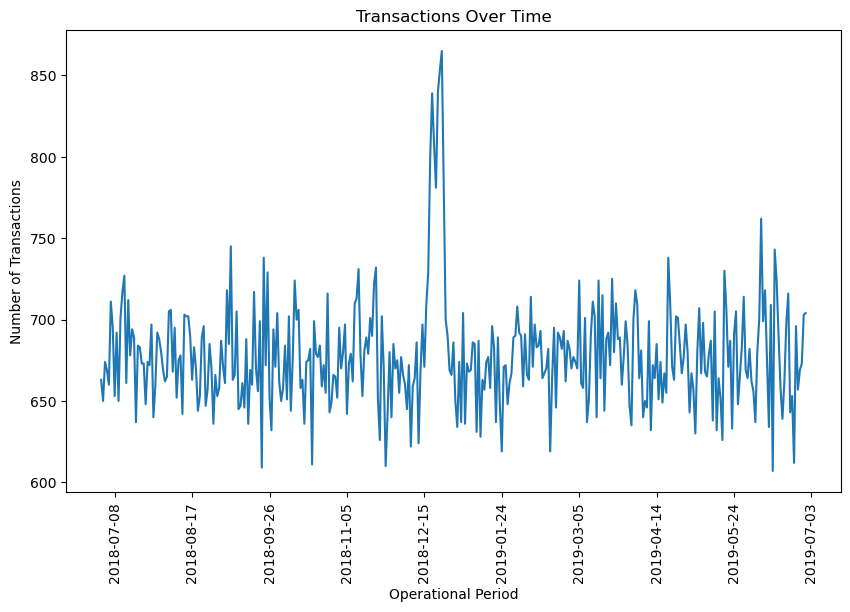

In [215]:
# Let's see the pictorial view for transactions over time

plt.figure(figsize=(10,6))

# line plot for transactions over time vs count of transactions
ax = sns.lineplot(x='Date', y='Count', data=merged_df)

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.title('Transactions Over Time')
plt.ylabel('Number of Transactions')
plt.xlabel('Operational Period')

# set break for start of each month
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=12))

#### Looks like there is some odd trend at the time of december end. Let's dig in a little.

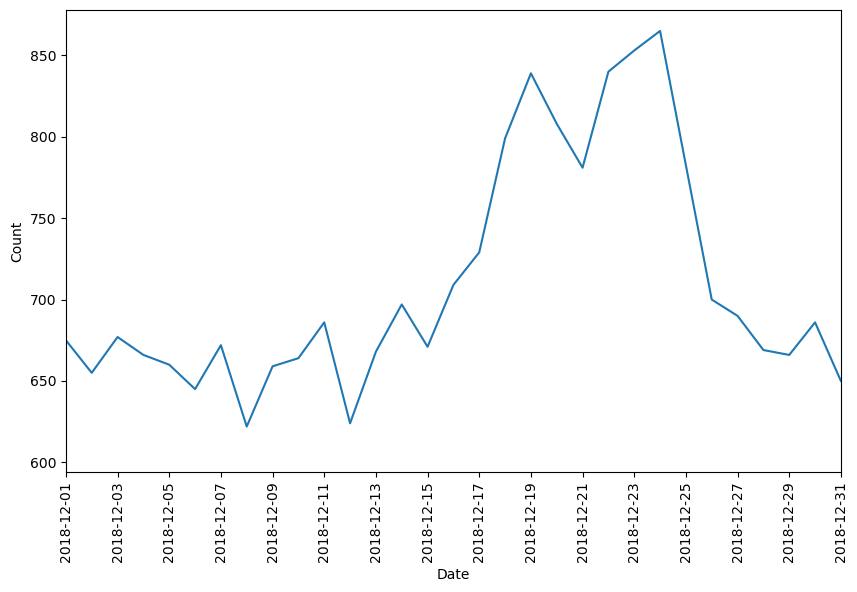

In [117]:
# Plotting graph for december month

plt.figure(figsize=(10,6))
ax = sns.lineplot(x='Date', y='Count', data=merged_df)
plt.xticks(rotation=90)
ax.set_xlim(pd.Timestamp('2018-12-01'), pd.Timestamp('2018-12-31'))
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=15))

#### We can see in the graph that transactions are high from Dec 17 due to "Christmas Week" and going down by 25 due to low closed shops on Christmas Day. Therefore, we can say that the data is accurate and not missing any date.

In [118]:
# Let's extract and analyze the pack size from the PROD_NAME

# function to find numbers from PROD_NAME

def find_num(name):
    
    match = re.search('\d+', name)
    return int(match.group())

transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].apply(find_num)

In [119]:
bot = transaction_data['PACK_SIZE'].value_counts().sort_index().index

(array([ 1507.,  3008., 22387.,  1454., 25102.,  3257., 40203.,  2970.,
        15297., 19983., 66390.,  1468.,  2995.,  4473.,  6272.,  1564.,
         3169.,  6285., 18956.]),
 array([ 70,  90, 110, 125, 134, 135, 150, 160, 165, 170, 175, 180, 190,
        200, 210, 220, 250, 270, 330, 380], dtype=int64),
 <BarContainer object of 19 artists>)

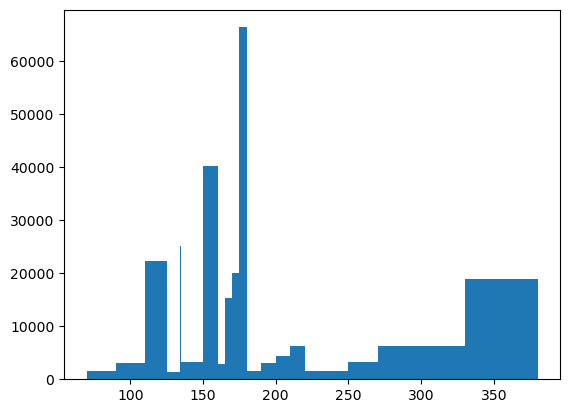

In [120]:
plt.hist(transaction_data['PACK_SIZE'], bins = bot, stacked = False)

In [175]:
# Let's extract and analyze the pack brand from the PROD_NAME

# function to find first word from PROD_NAME
def find_brand(name):
    match = re.split('\s', name)[0]
    return match

transaction_data['BRAND'] = transaction_data['PROD_NAME'].apply(find_brand)

In [176]:
transaction_data['BRAND'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [177]:
brand_replacements = {
    'Red': 'RRD',
    'Snbts': 'Sunbites',
    'Infzns': 'Infuzions',
    'WW': 'Woolworths',
    'Smith': 'Smiths',
    'NCC': 'Natural',
    'Dorito': 'Doritos',
    'Grain': 'GrnWves'
}

transaction_data['BRAND'] = transaction_data['BRAND'].replace(brand_replacements)

In [178]:
transaction_data['BRAND'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'GrnWves', 'Doritos',
       'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'RRD', 'Pringles', 'Tyrrells', 'Cobs', 'French',
       'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

#### Customer Data

In [179]:
customer_data.head(5)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [180]:
# Checking the data types and count of rows in customer_data
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [181]:
# Checking numerical columns
customer_data.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


In [182]:
# checking if there is any nulls
customer_data.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [183]:
# Let's see the unique categories in the dataset

print('PREMIUM_CUSTOMER:\n',customer_data['PREMIUM_CUSTOMER'].unique())
print('\n LIFESTAGE \n', customer_data['LIFESTAGE'].unique())

PREMIUM_CUSTOMER:
 ['Premium' 'Mainstream' 'Budget']

 LIFESTAGE 
 ['YOUNG SINGLES/COUPLES' 'YOUNG FAMILIES' 'OLDER SINGLES/COUPLES'
 'MIDAGE SINGLES/COUPLES' 'NEW FAMILIES' 'OLDER FAMILIES' 'RETIREES']


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

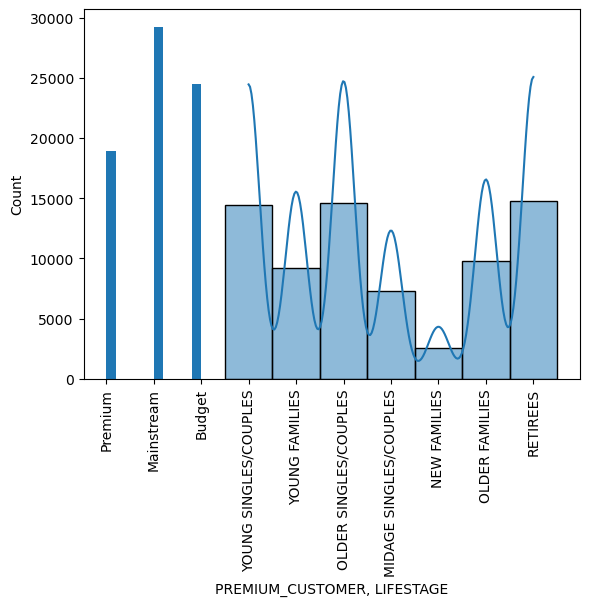

In [184]:
# Looking at the distributions of categories

plt.hist(customer_data['PREMIUM_CUSTOMER'])

sns.histplot(data = customer_data['LIFESTAGE'], kde = True)

plt.xlabel("PREMIUM_CUSTOMER, LIFESTAGE")
plt.xticks(rotation=90)

#### Customer_data looks good. Let's merge customer and transaction data now.

In [185]:
# Merging customer data and transaction data

final_data = pd.merge(transaction_data, customer_data, on = 'LYLTY_CARD_NBR', how = 'left')
final_data.shape

(246740, 12)

In [186]:
# Let's check for nulls
final_data.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [187]:
# let's check for columns info now
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 246739
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              246740 non-null  datetime64[ns]
 1   STORE_NBR         246740 non-null  int64         
 2   LYLTY_CARD_NBR    246740 non-null  int64         
 3   TXN_ID            246740 non-null  int64         
 4   PROD_NBR          246740 non-null  int64         
 5   PROD_NAME         246740 non-null  object        
 6   PROD_QTY          246740 non-null  int64         
 7   TOT_SALES         246740 non-null  float64       
 8   PACK_SIZE         246740 non-null  int64         
 9   BRAND             246740 non-null  object        
 10  LIFESTAGE         246740 non-null  object        
 11  PREMIUM_CUSTOMER  246740 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 24.5+ MB


#### Since, we don't have any nulls, we can clearly say that all the transactions are mapped to the customers.

In [188]:
# Let's export this data table for future use now.
final_data.to_csv('final_data.csv')

In [189]:
final_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [205]:
final_data['TOT_SALES'].groupby(final_data['LIFESTAGE']).sum().sort_values(ascending=False)

LIFESTAGE
OLDER SINGLES/COUPLES     376019.65
RETIREES                  342381.90
OLDER FAMILIES            328519.90
YOUNG FAMILIES            294627.90
YOUNG SINGLES/COUPLES     243756.60
MIDAGE SINGLES/COUPLES    172523.80
NEW FAMILIES               47347.95
Name: TOT_SALES, dtype: float64

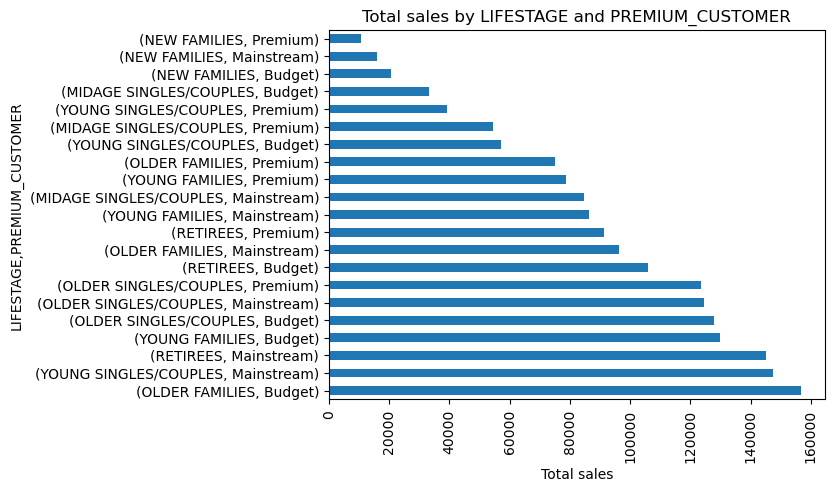

In [208]:
# Total sales by LIFESTAGE and PREMIUM_CUSTOMER
tot_sales_by_lifestage_premium = final_data['TOT_SALES'].groupby([final_data['LIFESTAGE'], final_data['PREMIUM_CUSTOMER']]).sum()
tot_sales_by_lifestage_premium.sort_values(ascending = False).plot(kind = 'barh')

plt.title('Total sales by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xlabel('Total sales')
plt.xticks(rotation = 90)
plt.show()

#### Highest Sales: (Older families, budget)  -> (Young Singles/Couples, Mainstream) -> (Retirees, Mainstream)

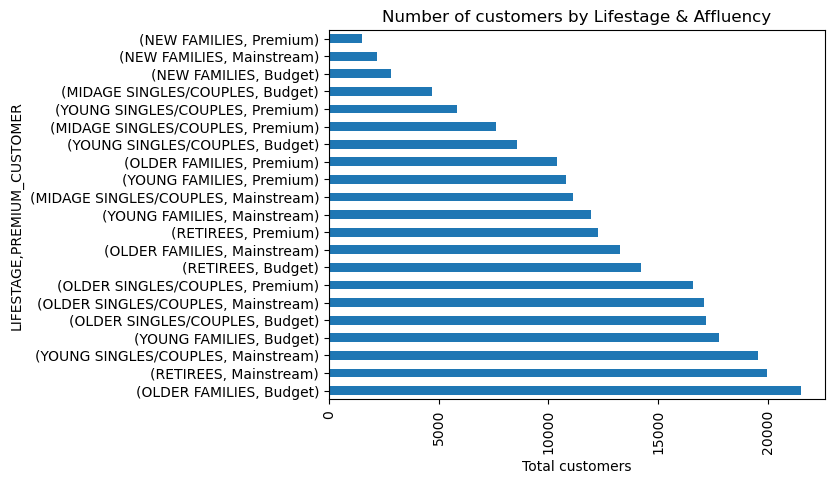

In [213]:
# Number of customers by LIFESTAGE and PREMIUM_CUSTOMER
tot_cust_by_lifestage_premium = final_data['TXN_ID'].groupby([final_data['LIFESTAGE'], final_data['PREMIUM_CUSTOMER']]).count()
tot_cust_by_lifestage_premium.sort_values(ascending = False).plot(kind = 'barh')

plt.title('Number of customers by Lifestage & Affluency')
plt.xlabel('Total customers')
plt.xticks(rotation = 90)
plt.show()

In [192]:
tot_cust_by_lifestage_premium.sort_values(ascending = False)

LIFESTAGE               PREMIUM_CUSTOMER
OLDER FAMILIES          Budget              21514
RETIREES                Mainstream          19970
YOUNG SINGLES/COUPLES   Mainstream          19544
YOUNG FAMILIES          Budget              17763
OLDER SINGLES/COUPLES   Budget              17172
                        Mainstream          17061
                        Premium             16560
RETIREES                Budget              14225
OLDER FAMILIES          Mainstream          13241
RETIREES                Premium             12236
YOUNG FAMILIES          Mainstream          11947
MIDAGE SINGLES/COUPLES  Mainstream          11095
YOUNG FAMILIES          Premium             10784
OLDER FAMILIES          Premium             10403
YOUNG SINGLES/COUPLES   Budget               8573
MIDAGE SINGLES/COUPLES  Premium              7612
YOUNG SINGLES/COUPLES   Premium              5852
MIDAGE SINGLES/COUPLES  Budget               4691
NEW FAMILIES            Budget               2824
         

#### (OLDER FAMILIES, Budget), (RETIREES, Mainstream) & (YOUNG SINGLES/COUPLES, Mainstream) are top 3 customer segments who bought highest number of chips. Mainstream group is buying more chips than any other group.

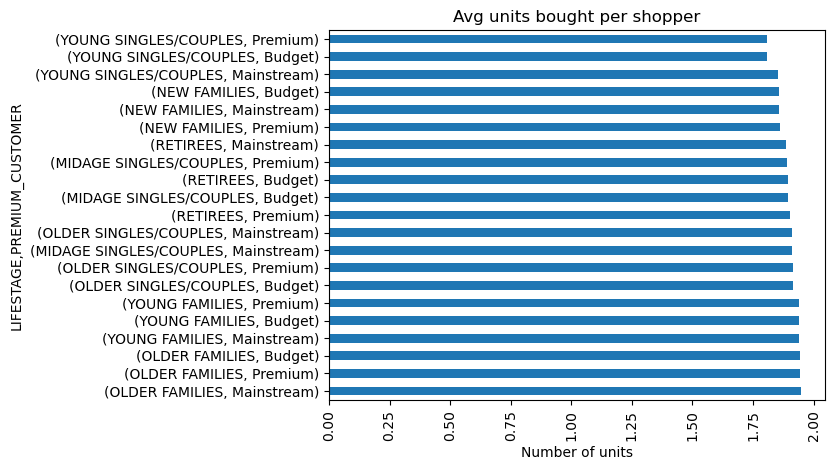

In [214]:
# Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
avg_num_items_by_lifestage_premium = final_data['PROD_QTY'].groupby([final_data['LIFESTAGE'],
                                                                     final_data['PREMIUM_CUSTOMER']]).mean()
avg_num_items_by_lifestage_premium.sort_values(ascending = False).plot(kind = 'barh')

plt.title('Avg units bought per shopper')
plt.xlabel('Number of units')
plt.xticks(rotation = 90)
plt.show()

In [194]:
avg_num_items_by_lifestage_premium.sort_values(ascending=False)

LIFESTAGE               PREMIUM_CUSTOMER
OLDER FAMILIES          Mainstream          1.948795
                        Premium             1.945496
                        Budget              1.945384
YOUNG FAMILIES          Mainstream          1.941408
                        Budget              1.941226
                        Premium             1.938149
OLDER SINGLES/COUPLES   Budget              1.914920
                        Premium             1.913949
MIDAGE SINGLES/COUPLES  Mainstream          1.911942
OLDER SINGLES/COUPLES   Mainstream          1.911201
RETIREES                Premium             1.901438
MIDAGE SINGLES/COUPLES  Budget              1.893626
RETIREES                Budget              1.893286
MIDAGE SINGLES/COUPLES  Premium             1.891750
RETIREES                Mainstream          1.886680
NEW FAMILIES            Premium             1.860887
                        Mainstream          1.858124
                        Budget              1.855878
YOUNG

#### OLDER FAMILIES, YOUNG FAMILIES in general are buying more number of chips per customer. This could be due to they are buying for the whole family.

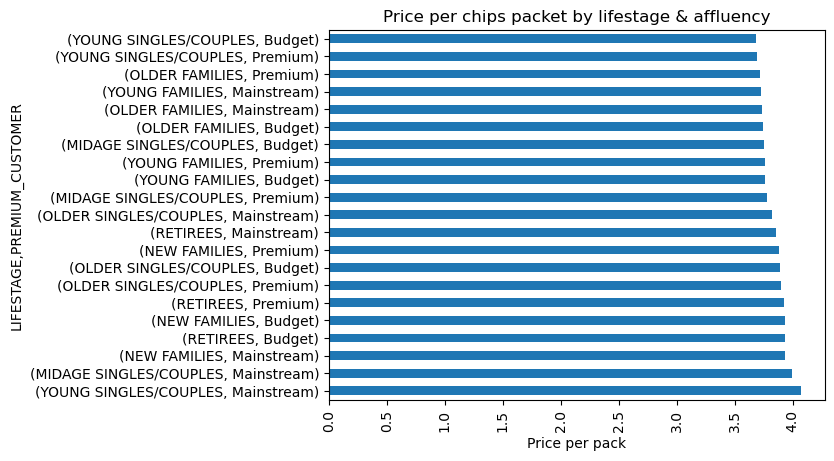

In [212]:
# Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER
avg_price_item_by_lifestage_premium = final_data['TOT_SALES'].groupby([final_data['LIFESTAGE'],
                                                                       final_data['PREMIUM_CUSTOMER']]).sum() /final_data['PROD_QTY'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).sum()


avg_price_item_by_lifestage_premium.sort_values(ascending = False).plot(kind = 'barh')
plt.xlabel('Price per pack')
plt.title('Price per chips packet by lifestage & affluency')
plt.xticks(rotation = 90)
plt.show()

In [196]:
avg_price_item_by_lifestage_premium.sort_values(ascending = False)

LIFESTAGE               PREMIUM_CUSTOMER
YOUNG SINGLES/COUPLES   Mainstream          4.074043
MIDAGE SINGLES/COUPLES  Mainstream          3.994449
NEW FAMILIES            Mainstream          3.935887
RETIREES                Budget              3.932731
NEW FAMILIES            Budget              3.931969
RETIREES                Premium             3.924037
OLDER SINGLES/COUPLES   Premium             3.897698
                        Budget              3.887529
NEW FAMILIES            Premium             3.886168
RETIREES                Mainstream          3.852986
OLDER SINGLES/COUPLES   Mainstream          3.822753
MIDAGE SINGLES/COUPLES  Premium             3.780823
YOUNG FAMILIES          Budget              3.761903
                        Premium             3.759232
MIDAGE SINGLES/COUPLES  Budget              3.753878
OLDER FAMILIES          Budget              3.747969
                        Mainstream          3.736380
YOUNG FAMILIES          Mainstream          3.722439
OLDER

#### Mainstream (Young age and Midage Singles/Couples) are willing to pay more per packet of chips than any other segment. This could be due to Premium people prefer buying chips barely as they focus more on healthy products. Also, Budget people tends not to spend too much on chips. 

#### Let's check if there is actually a significant difference between Mainstream(Young & Midage Singles/Couples) and their counterparts, Premium & Budget (Young & Midage Singles/Couples).

In [197]:
# Grouping and get data by groups

midage_mainstream = final_data['TOT_SALES'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('MIDAGE SINGLES/COUPLES', 'Mainstream'))/final_data['PROD_QTY'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('MIDAGE SINGLES/COUPLES', 'Mainstream'))

midage_premium = final_data['TOT_SALES'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('MIDAGE SINGLES/COUPLES', 'Premium'))/final_data['PROD_QTY'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('MIDAGE SINGLES/COUPLES', 'Premium'))

midage_budget = final_data['TOT_SALES'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('MIDAGE SINGLES/COUPLES', 'Budget'))/final_data['PROD_QTY'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('MIDAGE SINGLES/COUPLES', 'Budget'))

young_mainstream = final_data['TOT_SALES'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('YOUNG SINGLES/COUPLES', 'Mainstream'))/final_data['PROD_QTY'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('YOUNG SINGLES/COUPLES', 'Mainstream'))

young_premium = final_data['TOT_SALES'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('YOUNG SINGLES/COUPLES', 'Premium'))/final_data['PROD_QTY'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('YOUNG SINGLES/COUPLES', 'Premium'))

young_budget = final_data['TOT_SALES'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('YOUNG SINGLES/COUPLES', 'Budget'))/final_data['PROD_QTY'].groupby([final_data['LIFESTAGE'],final_data['PREMIUM_CUSTOMER']]).get_group(('YOUNG SINGLES/COUPLES', 'Budget'))

In [198]:
from scipy.stats import ttest_ind

# Perform t-tests
t_test_midage_mainstream_premium = ttest_ind(midage_mainstream, midage_premium, equal_var=False)
print('(Midage Singles/Couples: Mainstream vs Premium) p_val: ', t_test_midage_mainstream_premium[1])
if(t_test_midage_mainstream_premium[1] < 0.05): 
    print('Since pval < 0.05, we can say that the unit price for mainstream is significantly higher than for premium.')

t_test_midage_mainstream_budget = ttest_ind(midage_mainstream, midage_budget, equal_var=False)
print('\n(Midage Singles/Couples: Mainstream vs Budget) p_val: ', t_test_midage_mainstream_budget[1])
if(t_test_midage_mainstream_budget[1] < 0.05): 
    print('Since pval < 0.05, we can say that the unit price for mainstream is significantly higher than for budget.')

t_test_young_mainstream_premium = ttest_ind(young_mainstream, young_premium, equal_var=False)
print('\n(Young Singles/Couples: Mainstream vs Premium) p_val: ', t_test_young_mainstream_premium[1])
if(t_test_young_mainstream_premium[1] < 0.05): 
    print('Since pval < 0.05, we can say that the unit price for mainstream is significantly higher than for premium.')

t_test_young_mainstream_budget = ttest_ind(young_mainstream, young_budget, equal_var=False)
print('\n(Young Singles/Couples: Mainstream vs Budget) p_val: ', t_test_young_mainstream_budget[1])
if(t_test_young_mainstream_budget[1] < 0.05): 
    print('Since pval < 0.05, we can say that the unit price for mainstream is significantly higher than for budget.')

(Midage Singles/Couples: Mainstream vs Premium) p_val:  1.2705045169661103e-44
Since pval < 0.05, we can say that the unit price for mainstream is significantly higher than for premium.

(Midage Singles/Couples: Mainstream vs Budget) p_val:  7.064596224398621e-41
Since pval < 0.05, we can say that the unit price for mainstream is significantly higher than for budget.

(Young Singles/Couples: Mainstream vs Premium) p_val:  4.0639607781958196e-131
Since pval < 0.05, we can say that the unit price for mainstream is significantly higher than for premium.

(Young Singles/Couples: Mainstream vs Budget) p_val:  2.795698078070072e-186
Since pval < 0.05, we can say that the unit price for mainstream is significantly higher than for budget.


#### Overall, it can be concluded that the unit price for mainstream, young and mid-age singles and couples [are] significantly higher than that of budget or premium, young and midage singles and couples. 

#### Let's find out mainstream, yound single/couples prefer which brands over others. We can focus on this group as we are getting most sales out of it, and company definitely wants to retain them.

In [199]:
# Let's find out which BRAND our customer segment loves the most.

# filtering our segment and other segments data
segment_data = final_data[(final_data['PREMIUM_CUSTOMER'] == 'Mainstream') & (final_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]
other_data = final_data[~(final_data['PREMIUM_CUSTOMER'] == 'Mainstream') & (final_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]

# Calculating total sum of segment prod_qty and other_prod_qty
segment_qty = segment_data['PROD_QTY'].sum()
other_qty = other_data['PROD_QTY'].sum()

# Calculating segment prod_qty %
segment_brand = segment_data['PROD_QTY'].groupby(segment_data['BRAND']).sum().reset_index()
segment_brand['SEGMENT'] = segment_brand['PROD_QTY'] / segment_qty

# Calculating other prod_qty %
other_brand = other_data['PROD_QTY'].groupby(other_data['BRAND']).sum().reset_index()
other_brand['OTHER'] = other_brand['PROD_QTY'] /other_qty

# Merging prod_qty% of both data 
brand_comparison = pd.merge(segment_brand[['BRAND', 'SEGMENT']], other_brand[['BRAND', 'OTHER']], on = 'BRAND')
brand_comparison['QTY_DIFF']  = brand_comparison['SEGMENT']/brand_comparison['OTHER']

brand_comparison.sort_values(by = 'QTY_DIFF', ascending = False)


,BRAND,SEGMENT,OTHER,QTY_DIFF
5,Doritos,0.122761,0.090431,1.357498
9,Kettle,0.197985,0.146539,1.351074
16,Tostitos,0.045411,0.034094,1.331926
18,Tyrrells,0.031553,0.023854,1.322732
17,Twisties,0.046184,0.035091,1.316106
11,Pringles,0.119420,0.096299,1.240097
8,Infuzions,0.064679,0.053883,1.200361
4,Cobs,0.044638,0.037354,1.194997
7,GrnWves,0.032712,0.029875,1.094956
15,Thins,0.060373,0.056107,1.076020


#### We can clearly see that their brand preference is Kettle, followed by Doritos. Talking about mainstream, yound single/couples, it can also be noticed that Kettle & Doritos Chips are chosen by them 35% more than any other groups. Apparently, Burger chips are preffered 64% less by mainstream, yound single/couples as compared to other groups.

In [202]:
# Let's find out which PACK_SIZE of Kettle chips our customer segment loves the most.
filtered_data = final_data[(final_data['PREMIUM_CUSTOMER'] == 'Mainstream') & (final_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (final_data['BRAND'] == 'Kettle')]
grouped_data = filtered_data['PROD_QTY'].groupby([filtered_data['LIFESTAGE'],filtered_data['PREMIUM_CUSTOMER'],filtered_data['PACK_SIZE'],filtered_data['BRAND']]).sum()
grouped_data.sort_values(ascending=False).head(5)

LIFESTAGE              PREMIUM_CUSTOMER  PACK_SIZE  BRAND 
YOUNG SINGLES/COUPLES  Mainstream        150        Kettle    3329
                                         175        Kettle    3308
                                         135        Kettle     535
Name: PROD_QTY, dtype: int64

#### Our segment highly prefers Kettle chips of PACK_SIZE 150g & 175G over all the other sizes.

## Conclusion:

### Sales have mostly come from Budget-older families, Mainstream-young singles/couples, and Mainstream-retirees. Young singles/couples and retirees in the mainstream category spend a lot on chips because there are more of them than other buyers. Mainstream, midage and young singles and couples also tend to pay more per packet, which suggests they're making impulse buys.

### We found that young singles and couples in the mainstream group really like Kettle chips which is about 35% more than any other groups, especially the 150g and 175g sizes. To boost sales, the Category Manager could place Kettle chips and smaller packs in spots where young singles and couples shop often. This would make the chips more visible and encourage more impulse buys.